# Exploratory Data Analysis

Nick Sciarrilli <br>
Comp 4449 <br>
Final <br>
03.09.2022

#### Berkeley DeepDrive 

The purpose of this notebook is to better understand the bdd100k dataset. I will randomly sample 10,000 images and we will look into the details of what are in the images.


In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_json(f):
    with open(f, 'r') as fp:
        return json.load(fp)
    
file = '../../datasets/bdd100k/train/ins_seg_train_cocofmt.json'

# raw is a list with 10,000 json samples
raw = load_json(file)
#raw = list(np.random.choice(raw, size=10000, replace=False))

In [3]:
raw.keys()

dict_keys(['type', 'categories', 'images', 'annotations'])

In [4]:
categoriesDF = pd.DataFrame.from_dict(raw['categories'])
annotationsDF = pd.DataFrame.from_dict(raw['annotations'])
annotationsDF.set_index('id', inplace=True)
annotationsDF

,image_id,category_id,instance_id,iscrowd,bbox,area,segmentation
id,,,,,,,
1,1,3,1,False,"[634.0, 229.0, 17.0, 26.0]",136,{'counts': '^Pn=a0ne017IEF`ZO9_e0IaZO6_e0KaZO5...
2,1,3,2,False,"[781.0, 217.0, 39.0, 31.0]",461,{'counts': '^[Ua02^f02N2N2N0O1O1O100O100O1XZOD...
3,1,1,3,False,"[722.0, 188.0, 16.0, 13.0]",176,{'counts': 'Tkk?4[f02I600O100000000000000001O0...
4,1,3,4,False,"[636.0, 201.0, 164.0, 141.0]",15118,{'counts': 'Z]o=:Vf00000000nYONa0NZd04S[O1b0MY...
5,1,3,5,False,"[1014.0, 204.0, 147.0, 41.0]",2520,{'counts': 'bUYf01_f00O10000O100O101N100000000...
...,...,...,...,...,...,...,...
89161,7000,3,3,False,"[124.0, 333.0, 118.0, 76.0]",5527,{'counts': '[ag23\f02M3N2M3N1N4M2N1N2O1N2O1N2O...
89162,7000,3,4,False,"[202.0, 330.0, 199.0, 114.0]",16951,{'counts': '\]^4?oe05L3M3C<L4L3M3N3M2O101N100O...
89163,7000,3,5,False,"[353.0, 324.0, 98.0, 79.0]",4272,{'counts': 'j`h72]f01O2O0O2N101N2O1O1O1O001O1N...


In [25]:
annotationsDF.groupby('image_id').size().mean()

12.939341169641562

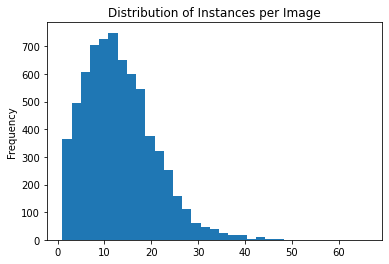

In [5]:
annotationsDF.groupby('image_id').size().plot(kind='hist', bins=33, title=('Distribution of Instances per Image'));

In [6]:
categoriesDF

,id,name
0,1,pedestrian
1,2,rider
2,3,car
3,4,truck
4,5,bus
5,6,train
6,7,motorcycle
7,8,bicycle


In [7]:
annotationsDF.loc[annotationsDF["category_id"] == 1, "category_id"] = 'pedestrian'
annotationsDF.loc[annotationsDF["category_id"] == 2, "category_id"] = 'rider'
annotationsDF.loc[annotationsDF["category_id"] == 3, "category_id"] = 'car'
annotationsDF.loc[annotationsDF["category_id"] == 4, "category_id"] = 'truck'
annotationsDF.loc[annotationsDF["category_id"] == 5, "category_id"] = 'bus'
annotationsDF.loc[annotationsDF["category_id"] == 6, "category_id"] = 'train'
annotationsDF.loc[annotationsDF["category_id"] == 7, "category_id"] = 'motorcycle'
annotationsDF.loc[annotationsDF["category_id"] == 8, "category_id"] = 'bicycle'


In [23]:
annotationsDF.groupby('category_id').size()

category_id
bicycle         818
bus            1633
car           72006
motorcycle      396
pedestrian     9933
rider           468
train            65
truck          3846
dtype: int64

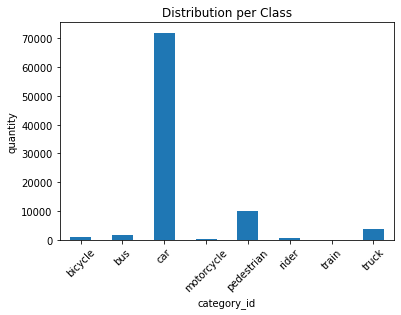

In [8]:
annotationsDF.groupby('category_id').size().plot(kind='bar', title='Distribution per Class', ylabel='quantity', rot=45);

# Histrogram of Colors

In [9]:
import os
import sys
import random
import math
import re
import time
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image, ImageDraw

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs/bdd100k")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/anaconda3/envs/mask

## Configurations

In [10]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import bdd100k
config = bdd100k.Bdd100kConfig()
COCO_DIR = '../../datasets/bdd100k/'  # TODO: enter value here


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  720
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [11]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

## Notebook Preferences

In [12]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [13]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [14]:
#os.listdir('../../datasets/bdd100k/val')

In [15]:
   

dataset = bdd100k.Bdd100kDataset()
dataset.load_bdd100k('../../datasets/bdd100k/val/ins_seg_val_cocofmt.json', '../../datasets/bdd100k/val')

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

100%|██████████| 1000/1000 [00:00<00:00, 135030.07it/s]

Images: 1000
Classes: ['BG', 'pedestrian', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']


In [16]:
#!pip3 install ipympl

In [17]:
images = os.listdir('../../datasets/bdd100k/val')

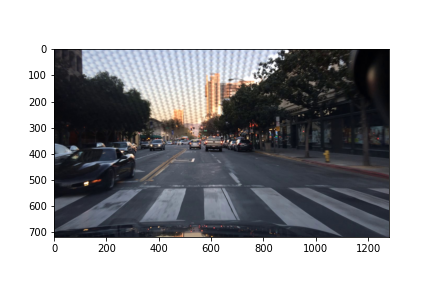

In [18]:
import os
import numpy as np
import skimage.color
import skimage.io
import matplotlib.pyplot as plt
%matplotlib widget

# read the image 
images = os.listdir('../../datasets/bdd100k/val')
#fname = dataset.load_image(np.random.choice(dataset.image_ids))
fname = os.path.join('../../datasets/bdd100k/val', np.random.choice(images))
image = skimage.io.imread(fname)

# display the image
fig, ax = plt.subplots()
plt.imshow(image)
plt.show()

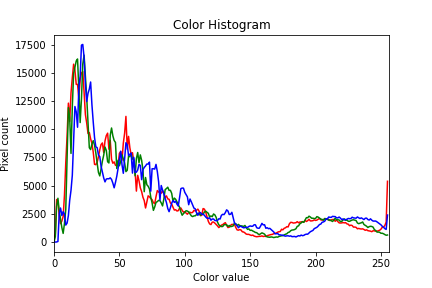

In [19]:
# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.figure()
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        image[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.title("Color Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

plt.show()

In [20]:
720*1280

921600

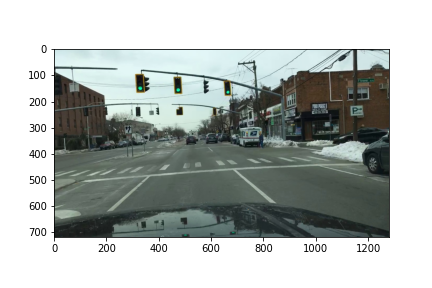

In [21]:
import os
import numpy as np
import skimage.color
import skimage.io
import matplotlib.pyplot as plt
%matplotlib widget

# read the image 
images = os.listdir('../../datasets/bdd100k/val')
#fname = dataset.load_image(np.random.choice(dataset.image_ids))
fname = os.path.join('../../datasets/bdd100k/val', np.random.choice(images))
image = skimage.io.imread(fname)

# display the image
fig, ax = plt.subplots()
plt.imshow(image)
plt.show()

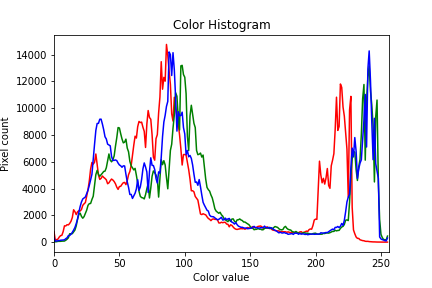

In [22]:
# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.figure()
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        image[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.title("Color Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

plt.show()

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_json(f):
    with open(f, 'r') as fp:
        return json.load(fp)
    
root = 'data/bdd100k'

# raw is a list with 10,000 json samples
raw = load_json(os.path.join(root, 'labels/bdd100k_labels_images_train.json'))
raw = list(np.random.choice(raw, size=10000, replace=False))

In [3]:
df = pd.DataFrame.from_dict(raw)

df.drop(columns='timestamp', inplace=True)
df

,name,attributes,labels
0,098cff6f-dccb9e35.jpg,"{'weather': 'overcast', 'scene': 'highway', 't...","[{'category': 'car', 'attributes': {'occluded'..."
1,9097a21a-93970ff5.jpg,"{'weather': 'clear', 'scene': 'highway', 'time...","[{'category': 'traffic sign', 'attributes': {'..."
2,59ac6b47-8566de5b.jpg,"{'weather': 'clear', 'scene': 'city street', '...","[{'category': 'traffic sign', 'attributes': {'..."
3,35d108d2-54fd804c.jpg,"{'weather': 'clear', 'scene': 'residential', '...","[{'category': 'car', 'attributes': {'occluded'..."
4,4cd5b47f-92b9c7f8.jpg,"{'weather': 'overcast', 'scene': 'highway', 't...","[{'category': 'car', 'attributes': {'occluded'..."
...,...,...,...
9995,8e2122c7-a5b877ce.jpg,"{'weather': 'clear', 'scene': 'city street', '...","[{'category': 'traffic sign', 'attributes': {'..."
9996,24d630ed-0b727c03.jpg,"{'weather': 'clear', 'scene': 'residential', '...","[{'category': 'car', 'attributes': {'occluded'..."
9997,a8613042-e019523a.jpg,"{'weather': 'clear', 'scene': 'highway', 'time...","[{'category': 'car', 'attributes': {'occluded'..."
9998,a554178d-a07d9073.jpg,"{'weather': 'clear', 'scene': 'highway', 'time...","[{'category': 'bus', 'attributes': {'occluded'..."


In [4]:
type(df.attributes.iloc[2])

dict

In [5]:
conditions = df.attributes.apply(pd.Series)
conditions

,weather,scene,timeofday
0,overcast,highway,daytime
1,clear,highway,night
2,clear,city street,night
3,clear,residential,daytime
4,overcast,highway,daytime
...,...,...,...
9995,clear,city street,night
9996,clear,residential,daytime
9997,clear,highway,night
9998,clear,highway,night


In [6]:
df = pd.concat([df, conditions], axis=1)
df.drop(columns='attributes', inplace=True)
df

,name,labels,weather,scene,timeofday
0,098cff6f-dccb9e35.jpg,"[{'category': 'car', 'attributes': {'occluded'...",overcast,highway,daytime
1,9097a21a-93970ff5.jpg,"[{'category': 'traffic sign', 'attributes': {'...",clear,highway,night
2,59ac6b47-8566de5b.jpg,"[{'category': 'traffic sign', 'attributes': {'...",clear,city street,night
3,35d108d2-54fd804c.jpg,"[{'category': 'car', 'attributes': {'occluded'...",clear,residential,daytime
4,4cd5b47f-92b9c7f8.jpg,"[{'category': 'car', 'attributes': {'occluded'...",overcast,highway,daytime
...,...,...,...,...,...
9995,8e2122c7-a5b877ce.jpg,"[{'category': 'traffic sign', 'attributes': {'...",clear,city street,night
9996,24d630ed-0b727c03.jpg,"[{'category': 'car', 'attributes': {'occluded'...",clear,residential,daytime
9997,a8613042-e019523a.jpg,"[{'category': 'car', 'attributes': {'occluded'...",clear,highway,night
9998,a554178d-a07d9073.jpg,"[{'category': 'bus', 'attributes': {'occluded'...",clear,highway,night


In [7]:
def bb_count(test_dict):
    bb = 0
    poly = 0
    for i in test_dict:
        #print(i)
        try:
            if i['box2d']:
                bb += 1
        except:
            pass

        try:
            if i['poly2d']:
                poly += 1
        except:
            continue
    return bb

df['label_counts'] = df.labels.apply(bb_count)
df

,name,labels,weather,scene,timeofday,label_counts
0,098cff6f-dccb9e35.jpg,"[{'category': 'car', 'attributes': {'occluded'...",overcast,highway,daytime,26
1,9097a21a-93970ff5.jpg,"[{'category': 'traffic sign', 'attributes': {'...",clear,highway,night,9
2,59ac6b47-8566de5b.jpg,"[{'category': 'traffic sign', 'attributes': {'...",clear,city street,night,12
3,35d108d2-54fd804c.jpg,"[{'category': 'car', 'attributes': {'occluded'...",clear,residential,daytime,19
4,4cd5b47f-92b9c7f8.jpg,"[{'category': 'car', 'attributes': {'occluded'...",overcast,highway,daytime,10
...,...,...,...,...,...,...
9995,8e2122c7-a5b877ce.jpg,"[{'category': 'traffic sign', 'attributes': {'...",clear,city street,night,6
9996,24d630ed-0b727c03.jpg,"[{'category': 'car', 'attributes': {'occluded'...",clear,residential,daytime,32
9997,a8613042-e019523a.jpg,"[{'category': 'car', 'attributes': {'occluded'...",clear,highway,night,6
9998,a554178d-a07d9073.jpg,"[{'category': 'bus', 'attributes': {'occluded'...",clear,highway,night,5


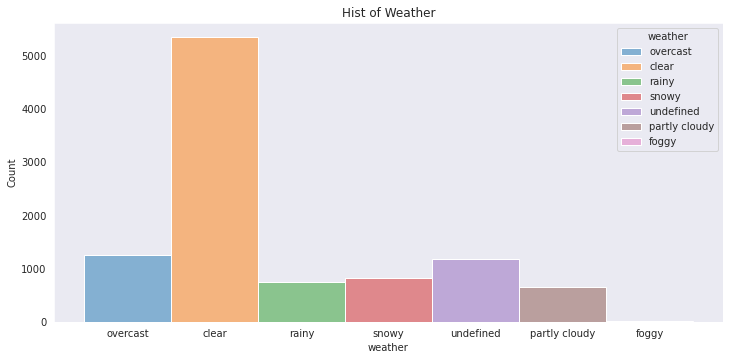

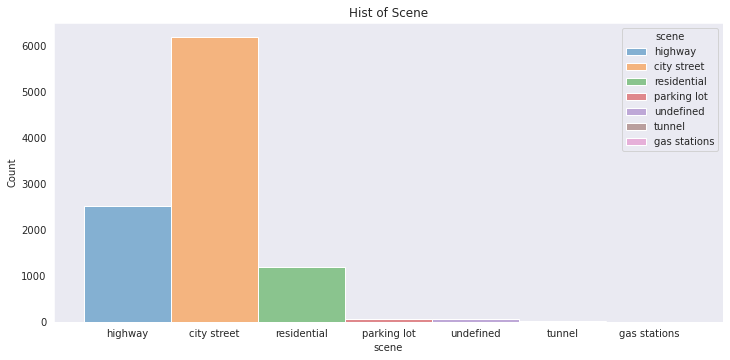

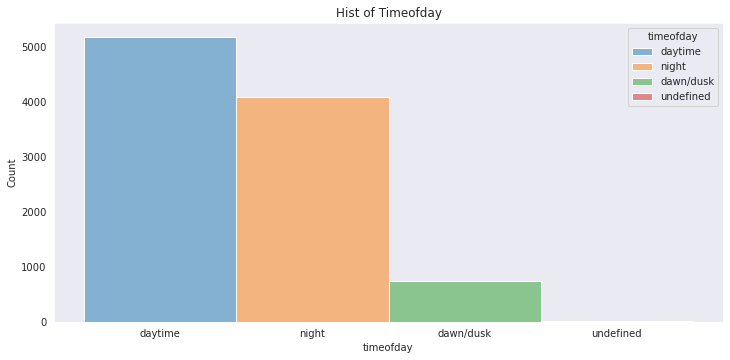

In [49]:
import seaborn as sns
sns.set_style("dark")

hist_cols = ['weather', 'scene', 'timeofday']
for col in hist_cols:
    fig, ax = plt.subplots(figsize=(12,5.5))
    sns.histplot(data=df, x=col, hue=col).set(title=f'Hist of {col.title()}');

In [9]:
# fig, ax = plt.subplots(figsize=(14,8))
# sns.histplot(data=df, x='label_counts', bins=69);

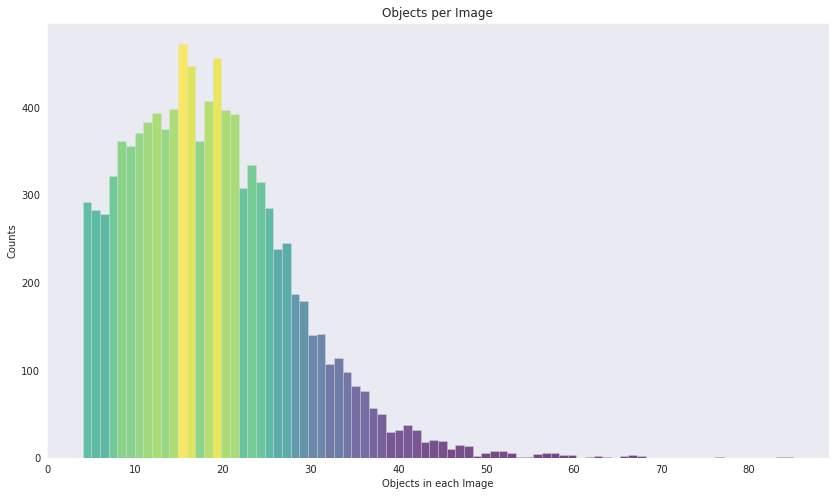

In [46]:
plt.figure(figsize=(14,8)) # Plot size
#plt.style.use('seaborn-whitegrid') # Style

# Building a histogram
n, bins, patches = plt.hist(df.label_counts, bins=82, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

# Changing properties of each bin
n = n.astype('int') # n should be integer, otherwise it wouldn't work properly

# Accessing each bin, changing color according to height
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

# Adding title and labels with custom font sizes
plt.title('Objects per Image', fontsize=12)
plt.xlabel('Objects in each Image', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.show()

In [11]:
# hist_cols = ['weather', 'scene', 'timeofday']

# for col in hist_cols:
#     temp = df[col].value_counts().to_frame()
#     fig, ax = plt.subplots(figsize=(12,5.5))
#     sns.barplot(x=temp.index, y=temp[col]).set(title=col.title(), xlabel=col, ylabel='count');

In [12]:
# hist_cols = ['weather', 'scene', 'timeofday']

# for col in hist_cols:
#     fig, ax = plt.subplots(figsize=(12,5.5))
#     sns.countplot(data=df, x=col, hue=col, order = df[col].value_counts().index);

In [13]:
test_dict = df.labels.iloc[0]

In [14]:
len(test_dict)

38

In [15]:
df.labels.apply(bb_count)

0       26
1        9
2       12
3       19
4       10
        ..
9995     6
9996    32
9997     6
9998     5
9999    12
Name: labels, Length: 10000, dtype: int64

In [16]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [17]:
from collections import defaultdict

In [18]:
labels = df.labels.iloc[0]

In [19]:
def object_counts(labels):
    counts = defaultdict(int)
    for label in labels:
        #print(label['category'])
        if label['category'] not in counts:
            counts[label['category']] = 1
        else:
            counts[label['category']] += 1
    return counts

In [20]:
object_counts(labels)

defaultdict(int,
            {'car': 20,
             'truck': 1,
             'traffic sign': 5,
             'drivable area': 3,
             'lane': 9})

In [21]:
df['object_counts'] = df.labels.apply(object_counts)

In [22]:
df

,name,labels,weather,scene,timeofday,label_counts,object_counts
0,098cff6f-dccb9e35.jpg,"[{'category': 'car', 'attributes': {'occluded'...",overcast,highway,daytime,26,"{'car': 20, 'truck': 1, 'traffic sign': 5, 'dr..."
1,9097a21a-93970ff5.jpg,"[{'category': 'traffic sign', 'attributes': {'...",clear,highway,night,9,"{'traffic sign': 5, 'car': 4, 'drivable area':..."
2,59ac6b47-8566de5b.jpg,"[{'category': 'traffic sign', 'attributes': {'...",clear,city street,night,12,"{'traffic sign': 2, 'traffic light': 2, 'perso..."
3,35d108d2-54fd804c.jpg,"[{'category': 'car', 'attributes': {'occluded'...",clear,residential,daytime,19,"{'car': 17, 'truck': 2, 'drivable area': 1, 'l..."
4,4cd5b47f-92b9c7f8.jpg,"[{'category': 'car', 'attributes': {'occluded'...",overcast,highway,daytime,10,"{'car': 9, 'traffic sign': 1, 'drivable area':..."
...,...,...,...,...,...,...,...
9995,8e2122c7-a5b877ce.jpg,"[{'category': 'traffic sign', 'attributes': {'...",clear,city street,night,6,"{'traffic sign': 3, 'car': 3, 'drivable area':..."
9996,24d630ed-0b727c03.jpg,"[{'category': 'car', 'attributes': {'occluded'...",clear,residential,daytime,32,"{'car': 23, 'traffic sign': 9, 'drivable area'..."
9997,a8613042-e019523a.jpg,"[{'category': 'car', 'attributes': {'occluded'...",clear,highway,night,6,"{'car': 3, 'traffic light': 3, 'drivable area'..."
9998,a554178d-a07d9073.jpg,"[{'category': 'bus', 'attributes': {'occluded'...",clear,highway,night,5,"{'bus': 1, 'car': 1, 'traffic sign': 3, 'driva..."


In [23]:
object_counts = df.object_counts.apply(pd.Series)
object_counts = object_counts.fillna(0)
object_counts

,car,truck,traffic sign,drivable area,lane,traffic light,person,bike,bus,rider,motor,train
0,20.0,1.0,5.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,5.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,1.0,2.0,2.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
3,17.0,2.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.0,0.0,1.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.0,0.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,23.0,0.0,9.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,3.0,0.0,0.0,2.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,1.0,0.0,3.0,2.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
object_counts.describe()

,car,truck,traffic sign,drivable area,lane,traffic light,person,bike,bus,rider,motor,train
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000
mean,10.231200,0.424100,3.394000,1.788300,7.455300,2.605800,1.262000,0.0988,0.166400,0.058100,0.041000,0.000900
std,6.167167,0.870009,3.204308,1.089129,5.094723,3.213696,3.235738,0.5554,0.498935,0.280236,0.242745,0.029988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,3.000000,1.000000,7.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
75%,14.000000,1.000000,5.000000,2.000000,10.000000,5.000000,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000
max,61.000000,11.000000,29.000000,7.000000,37.000000,20.000000,49.000000,15.0000,7.000000,4.000000,5.000000,1.000000


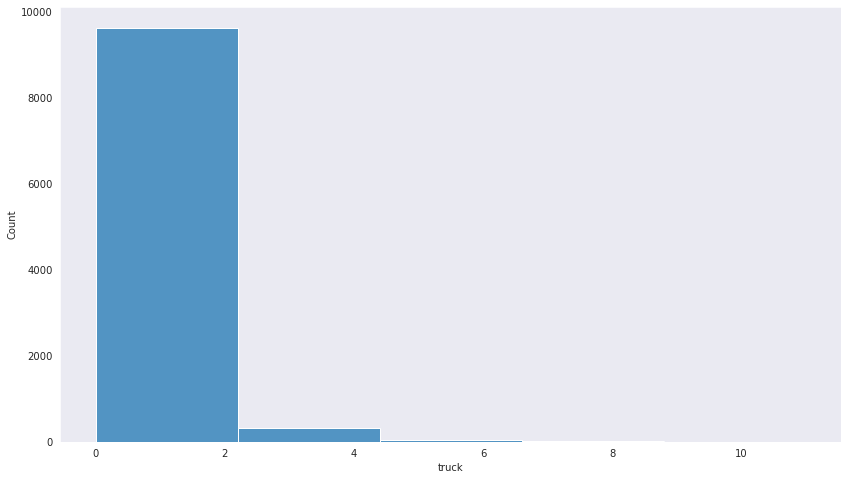

In [25]:
fig, ax = plt.subplots(figsize=(14,8))
sns.histplot(data=object_counts, x='truck', bins=5);

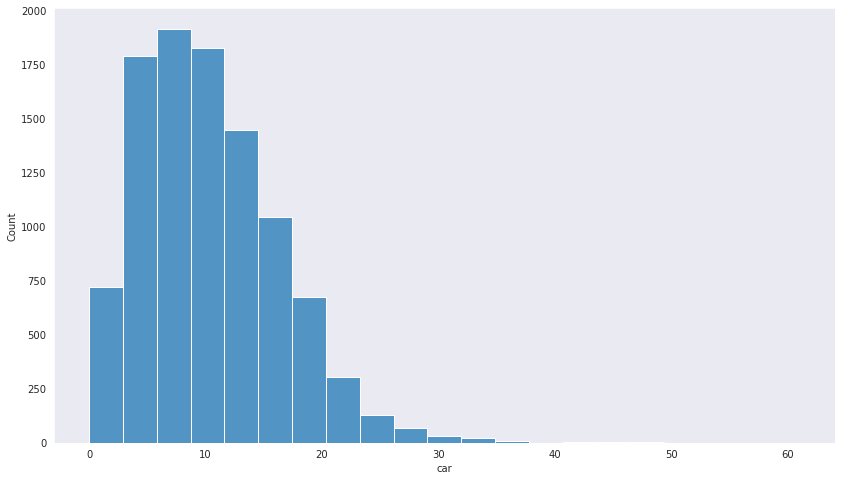

In [26]:
fig, ax = plt.subplots(figsize=(14,8))
sns.histplot(data=object_counts, x='car', bins=21);

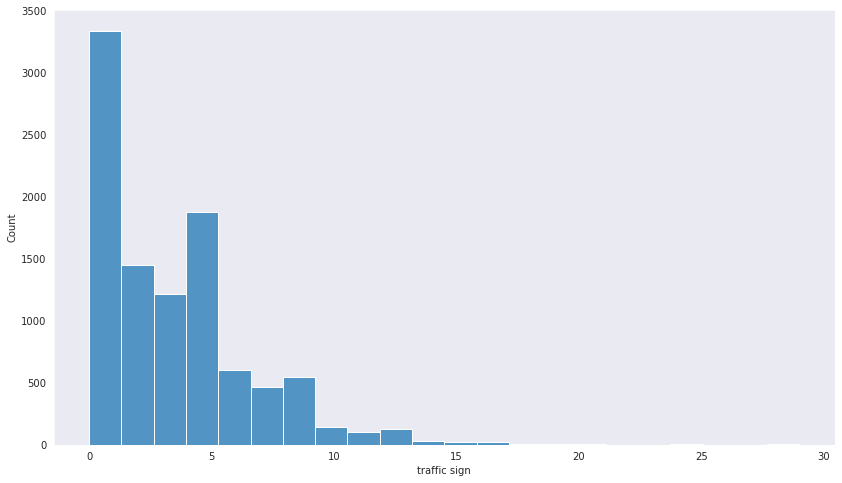

In [27]:
fig, ax = plt.subplots(figsize=(14,8))
sns.histplot(data=object_counts, x='traffic sign', bins=22);

# Appendix

In [28]:
import os
import json
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
# from torchvision.datasets.folder import pil_loader

from dataset import BDDDataset

In [51]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [53]:
drive_dataset = BDDDataset('data/bdd100k', get_transform(train=False))

In [55]:
len(drive_dataset)

9998

In [56]:
torch.manual_seed(0)

train_set, test_set, val_set = torch.utils.data.random_split(drive_dataset, [7000, 2000, 998 ])

In [57]:
len(train_set), len(test_set), len(val_set)

(7000, 2000, 998)

In [58]:
loader = DataLoader(drive_dataset,
                    batch_size=2,
                    shuffle=True)

In [59]:
loader.batch_size

2

In [60]:
loader.num_workers

0

In [61]:
len(loader.dataset)

9998

In [66]:
from torchvision import transforms
transform = transforms.Compose(
    [transforms.Resize(64), transforms.ToTensor()])

loader = DataLoader(
    BDDDataset('data/bdd100k', get_transform(train=True)),
    batch_size=2,
    shuffle=True)

val_loader = DataLoader(
    BDDDataset('data/bdd100k', get_transform(train=False)),
    batch_size=2,
    shuffle=True)

In [67]:
len(loader.dataset)

9998

In [68]:
len(val_loader.dataset)

9998

In [69]:
image, label = loader.dataset.__getitem__(2)

In [70]:
type(image)

torch.Tensor

In [71]:
from matplotlib.patches import Rectangle

# plt.imshow(image)
# plt.gca().add_patch(Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor='none'))
# plt.show()

In [72]:
label['labels'][0]

tensor(9)

In [73]:
len(label['labels'])

26

In [77]:
# label['labels'][0]['box2d']['x1']

In [76]:
# plt.imshow(image)
# x1 = label['labels'][0]['box2d']['x1']
# x2 = label['labels'][0]['box2d']['x2']
# y1 = label['labels'][0]['box2d']['y1']
# y2 = label['labels'][0]['box2d']['y2']

# print(x1, y1, x2, y2)

# x = x1
# y = y2
# w = x2 - x1
# h = y1 - y2

# plt.plot(x1, y1, marker='v', color="white")
# plt.plot(x2, y2, marker='v', color="white")

# plt.gca().add_patch(Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none'))
# plt.show()

In [ ]:
image.size[0]

In [ ]:
import numpy as np
colors = ['C'+str(i) for i in range(10)]

In [ ]:
np.random.choice(colors)

In [ ]:
def show_random_image(loader, idx=None):
    colors = ['C'+str(i) for i in range(10)]
    n = len(loader.dataset)
    
    if idx is None:
        idx = np.random.randint(0, n)
        image, label = loader.dataset.__getitem__(idx)
    else:
        image, label = loader.dataset.__getitem__(idx)

    fig, ax = plt.subplots(figsize = (21,14))
    ax.imshow(image)

    idx = 0
    for i in label['labels']:
        #print(idx)
        idx += 1
        try:
            x1 = i['box2d']['x1']
            x2 = i['box2d']['x2']
            y1 = i['box2d']['y1']
            y2 = i['box2d']['y2']

            #print(x1, y1, x2, y2)

            x = x1
            y = y2
            w = x2 - x1
            h = y1 - y2

            # plt.plot(x1, y1, marker='v', color="white")
            # plt.plot(x2, y2, marker='v', color="white")
            color = np.random.choice(colors)
            ax.add_patch(Rectangle((x,y), w, h, linewidth=1.5, edgecolor=color, facecolor='none'))

            cat = i['category']
            ax.text(x, y1-12, cat, verticalalignment='top', color='white', fontsize=11)
        except:
            continue
#plt.show()

show_random_image(loader)

In [ ]:
len(label['labels'])

In [ ]:
type(label['labels'])

In [ ]:
label['labels'][0]['category']

In [ ]:
# label

In [ ]:
image.size

In [ ]:
plt.figure(figsize=(25,15))
colors = ['C'+str(i) for i in range(10)]
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = np.random.randint(0, len(loader.dataset))
    image, label = loader.dataset.__getitem__(idx)
    for i in label['labels']:
        #print(idx)
        idx += 1
        try:
            x1 = i['box2d']['x1']
            x2 = i['box2d']['x2']
            y1 = i['box2d']['y1']
            y2 = i['box2d']['y2']

            #print(x1, y1, x2, y2)

            x = x1
            y = y2
            w = x2 - x1
            h = y1 - y2

            # plt.plot(x1, y1, marker='v', color="white")
            # plt.plot(x2, y2, marker='v', color="white")
            color = np.random.choice(colors)
            plt.gca().add_patch(Rectangle((x,y),w,h,linewidth=1,edgecolor=color,facecolor='none'))

            cat = i['category']

            plt.gca().text(x,y1-20,cat,verticalalignment='top',color='white',fontsize=11)
        except:
            continue
    plt.imshow(image)
    #plt.xlabel(class_names[train_labels[i]])
    plt.tight_layout
plt.show()